# Demo notebook showing arbok functionalities

This is a simple demo notebook containing the core functionalities of arbok

### Importing qm and arbok module

In [1]:
from qm.qua import *
from qm.QuantumMachinesManager import QuantumMachinesManager
from qm.simulate.credentials import create_credentials
from qm import SimulationConfig

2023-07-14 16:27:11,103 - qm - INFO     - Starting session: eb3d8ee8-3e31-4322-b84a-0bed8890b0ac


In [2]:
from arbok.core.sequence import Sequence
from arbok.core.sample import Sample

from arbok.samples.sunshine.readout.other_ST_read import OtherStReadout
from arbok.samples.sunshine.initialization.mixed_down_up_init import (
    MixedDownUpInit
)
from arbok.samples.sunshine.configs.rf2v_config import rf2v_config

### Instanciating Arbok modules

Firstly we instanciate `Sequence` objects describing initialization and readout

In [3]:
duInit = MixedDownUpInit('duInit')
stReadout = OtherStReadout('stReadout')
stReadout2 = OtherStReadout('stReadout20')

Next a `Sample` object is created containing the device config. With this we can create an empty `Sequence` that we will populate with other sequences in the following

In [4]:
sunshine = Sample('sunshine', rf2v_config)
qh = Sequence('CNOT', sample = sunshine)
qb = Sequence('CYY', sample = sunshine)

Note how parameters that have already been defined in 'qh' are skipped.

In [5]:
qh.add_subsequence(duInit, verbose = True)
qh.add_subsequence(stReadout, verbose = True)
qh.add_subsequence(stReadout2, verbose = True)

In [6]:
qb.add_subsequence(qh)
qb.add_subsequence(OtherStReadout('stReadout30'))

Hereby the QCoDeS `Parameter`s describing the respective sequenes are referenced
in the containing `Sequence`. Therefore changes in the subsequences take effect 
in the merged sequence

In [7]:
duInit.parent

<Sequence: CNOT>

In [8]:
print(duInit.tInitLoadMixed())
duInit.tInitLoadMixed(int(2e3/4))
print(duInit.tInitLoadMixed())

625000
500


In [9]:
qh.duInit.root_instrument

<Sequence: CYY>

### Simulating Sequences

The entire sequence can now be simulated. Note that 'tInitLoadMixed' and 'tPreControl' have been reduced for the sake of visibility.

In [10]:
qb.CNOT.stReadout.parent

<Sequence: CNOT>

2023-07-14 16:27:15,050 - qm - INFO     - Performing health check
2023-07-14 16:27:15,890 - qm - INFO     - Health check passed
2023-07-14 16:27:17,023 - qm - INFO     - Simulating program


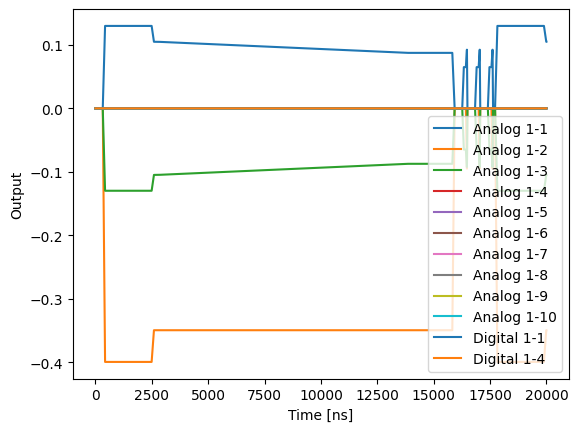

In [11]:
qb.CNOT.duInit.tPreControl(int(2e3/4))
qb.run_remote_simulation(duration = 5000)

2023-07-14 16:27:34,396 - qm - INFO     - Performing health check
2023-07-14 16:27:35,239 - qm - INFO     - Health check passed
2023-07-14 16:27:36,244 - qm - INFO     - Simulating program


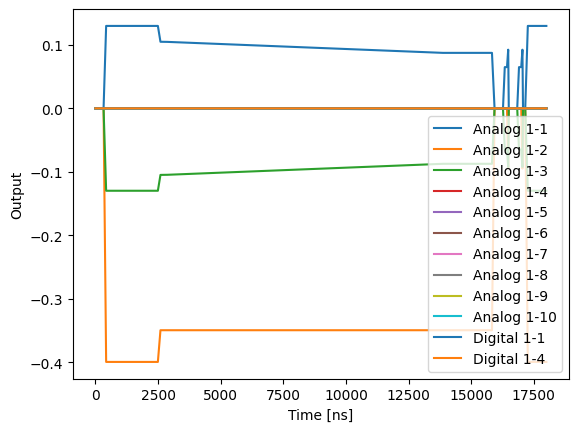

In [12]:
qh.duInit.tPreControl(int(2e3/4))
qh.run_remote_simulation(duration = 4500)

The subsequences can be run as well if we add a sample to their classes

In [13]:
duInit.submodules

{}

2023-07-14 16:27:49,614 - qm - INFO     - Performing health check
2023-07-14 16:27:50,453 - qm - INFO     - Health check passed
2023-07-14 16:27:51,172 - qm - INFO     - Simulating program


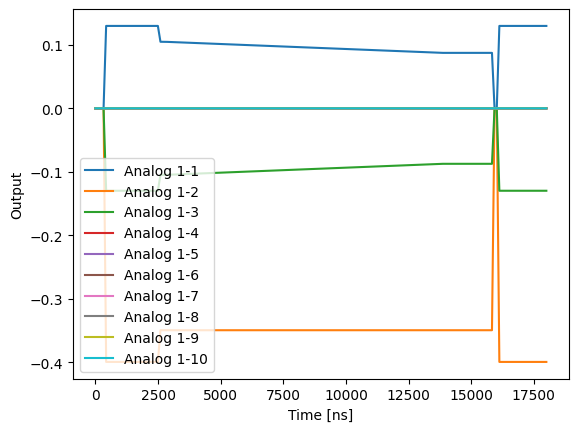

In [14]:
duInit.sample = sunshine
duInit.tPreControl(int(2e3/4))
duInit.run_remote_simulation(duration = 4500)

2023-07-14 16:28:04,912 - qm - INFO     - Performing health check
2023-07-14 16:28:05,765 - qm - INFO     - Health check passed
2023-07-14 16:28:06,534 - qm - INFO     - Simulating program


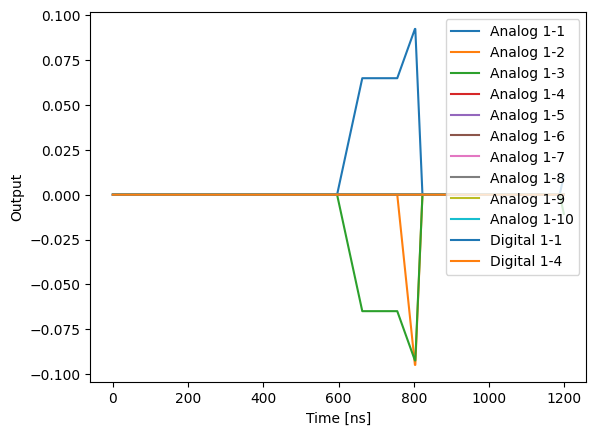

In [15]:
stReadout.sample = sunshine
stReadout.run_remote_simulation(duration = 300)

In [16]:
qh.submodules

{'duInit': <MixedDownUpInit: duInit>,
 'stReadout': <OtherStReadout: stReadout>,
 'stReadout20': <OtherStReadout: stReadout20>}

### Using the `Sequence` in the quantify-core library

In [17]:
import quantify_core.data.handling as dh
from quantify_core.measurement import MeasurementControl

In [18]:
dh.set_datadir(dh.default_datadir())

Data will be saved in:
C:\Users\z5440260\quantify-data


In [19]:
meas_ctrl = MeasurementControl('meas_ctrl')

In [20]:
import quantify_core.visualization.pyqt_plotmon as pqm

In [21]:
plotmon = pqm.PlotMonitor_pyqt("plotmon")
meas_ctrl.instr_plotmon(plotmon.name)

C:\Users\z5440260\AppData\Local\miniconda3\envs\temp_env\Lib\site-packages\quantify_core\visualization\pyqt_plotmon_remote.py:18: QCoDeSDeprecationWarning: The qcodes.plots is deprecated. Use "qcodes_loop.plots" as an alternative.
  from qcodes.plots.colors import color_cycle
C:\Users\z5440260\AppData\Local\miniconda3\envs\temp_env\Lib\site-packages\quantify_core\visualization\pyqt_plotmon_remote.py:18: QCoDeSDeprecationWarning: The qcodes.plots.colors is deprecated. Use "qcodes_loop.plots.colors" as an alternative.
  from qcodes.plots.colors import color_cycle
C:\Users\z5440260\AppData\Local\miniconda3\envs\temp_env\Lib\site-packages\qcodes\plots\pyqtgraph.py:17: QCoDeSDeprecationWarning: The qcodes.utils.qt_helpers module is deprecated. Use "qcodes_loop.utils.qt_helpers" as an alternative.
  import qcodes.utils.qt_helpers
C:\Users\z5440260\AppData\Local\miniconda3\envs\temp_env\Lib\site-packages\quantify_core\visualization\pyqt_plotmon_remote.py:19: QCoDeSDeprecationWarning: The qcod

In [22]:
from quantify_core.visualization.instrument_monitor import InstrumentMonitor

In [23]:
insmon = InstrumentMonitor("InstrumentMonitor")

In [24]:
qh.stReadout2.vHome_J1(100)

AttributeError: 'Sequence' object and its delegates have no attribute 'stReadout2'

In [ ]:
meas_ctrl.settables([qh.tControl, qh.tPreRead])
meas_ctrl.setpoints_grid([
    range(1,300), 
    range(100,300)
])

meas_ctrl.gettables()
#dset = meas_ctrl.run(name="Frequency sweep")

In [ ]:
qh.parameters.keys()

In [ ]:
readout.read_read.get_raw()

In [ ]:
if {'item':'some'}:
    print("not empty")

In [ ]:
qh.duInit.root_instrument

In [ ]:
qh.stReadout.parent

In [ ]:
qh.instrument_modules

In [ ]:
from qcodes.instrument import InstrumentModule

In [ ]:
im = InstrumentModule('test')